In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn
import math

from IPython import display

from scipy.linalg import fractional_matrix_power

tfd = tf.contrib.distributions

C:\Users\mishr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mishr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mishr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mishr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

# 0. Load the Data

In [2]:
fire_evac_train = np.load('FireEvac_train_set.npy')
fire_evac_test = np.load('FireEvac_test_set.npy')

# 1. Plot the Train and Test Sets

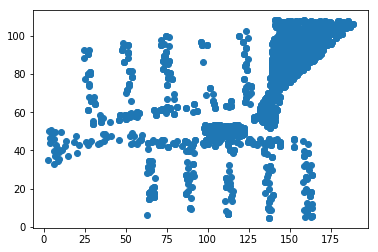

In [3]:
plt.scatter(fire_evac_train[:,0],fire_evac_train[:,1])

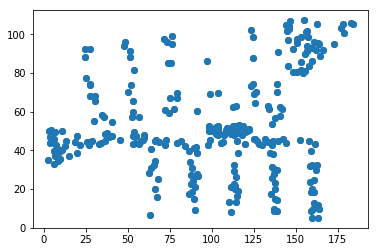

In [4]:
plt.scatter(fire_evac_test[:,0],fire_evac_test[:,1])

# 2. Variational Auto Encoder

Epoch 0 elbo -1846.09


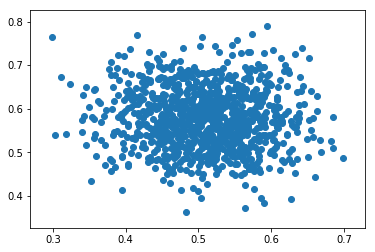

Epoch 1 elbo nan


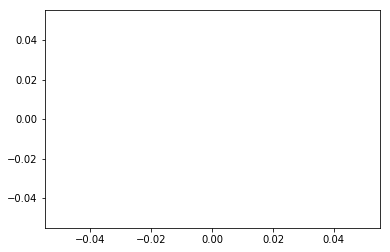

Epoch 2 elbo nan


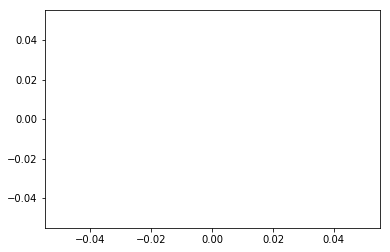

KeyboardInterrupt: 

In [12]:
def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
  loc = tf.zeros(code_size)
  scale = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)

data = tf.placeholder(tf.float32, [None, 1,2])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=50)
posterior = make_encoder(data, code_size=50)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [1, 2]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(1000), [1, 2]).mean()

def plot_samples(samples):
    plt.scatter(samples[:,:,0], samples[:,:,1])
    plt.show()

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(20):
    feed = {data: fire_evac_test.reshape([-1, 1, 2])}
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    plot_samples(test_samples)
    for _ in range(600):
      dim_st = epoch*150
      dim_end = dim_st+150
      feed = {data: fire_evac_train[dim_st: dim_end].reshape([-1, 1, 2])}
      sess.run(optimize, feed)

In [9]:
fire_evac_train[(0*150): (0*150 + 150)].reshape([-1, 1, 2]).shape

(150, 1, 2)